# 0. Setup 


Importing required modules and files.  
Using going_modular directory functions.  



In [1]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3812, done.
remote: Counting objects: 100% (455/455), done.
remote: Compressing objects: 100% (272/272), done.
remote: Total 3812 (delta 238), reused 351 (delta 176), pack-reused 3357
Receiving objects: 100% (3812/3812), 650.13 MiB | 32.45 MiB/s, done.
Resolving deltas: 100% (2194/2194), done.
Updating files: 100% (248/248), done.


In [2]:
# Device Agnostic Code 

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
import os 
import zipfile 
from pathlib import Path
import requests 
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

# 1. Getting Data 

## Getting larger dataset from Drive

In [4]:
import os 
import zipfile 
from pathlib import Path
import requests 

# Setup path to data folder 

data_path = Path("/kaggle/input/pizza-steak-sushi/data/") # The trailing forward slash (/) in the string 
                          # is used to indicate that it represents a 
                          # directory rather than a specific file. 
                          # It's a common convention to include the trailing slash 
                          # in directory paths to differentiate them from file paths.

image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory exists.")
walk_through_dir(image_path)

/kaggle/input/pizza-steak-sushi/data/pizza_steak_sushi directory exists.
There are 2 directories and 0 images in '/kaggle/input/pizza-steak-sushi/data/pizza_steak_sushi'.
There are 3 directories and 0 images in '/kaggle/input/pizza-steak-sushi/data/pizza_steak_sushi/test'.
There are 0 directories and 250 images in '/kaggle/input/pizza-steak-sushi/data/pizza_steak_sushi/test/steak'.
There are 0 directories and 250 images in '/kaggle/input/pizza-steak-sushi/data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 250 images in '/kaggle/input/pizza-steak-sushi/data/pizza_steak_sushi/test/pizza'.
There are 3 directories and 0 images in '/kaggle/input/pizza-steak-sushi/data/pizza_steak_sushi/train'.
There are 0 directories and 750 images in '/kaggle/input/pizza-steak-sushi/data/pizza_steak_sushi/train/steak'.
There are 0 directories and 750 images in '/kaggle/input/pizza-steak-sushi/data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 750 images in '/kaggle/input/pizza-st

# 2. Creating Datasets and DataLoaders

In [5]:

train_dir = image_path / "train"
test_dir = image_path / "test"


print(train_dir)
print(test_dir)

/kaggle/input/pizza-steak-sushi/data/pizza_steak_sushi/train
/kaggle/input/pizza-steak-sushi/data/pizza_steak_sushi/test


 ## 2.2 Creating a transform for torchvision.models (auto creation)

In [6]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [7]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [8]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7c623d611cc0>,
 ['pizza', 'steak', 'sushi'])

In [9]:
print(len(train_dataloader.dataset))
print(len(test_dataloader.dataset))

2250
750


# 3. Getting Pretrained Model

In [10]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
model = torchvision.models.efficientnet_b0(weights=weights).to(device)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 98.2MB/s]


## Getting model summary

In [11]:
# # Freeze all base layers in the "features" section of the model 
# (the feature extractor) by setting requires_grad=False

for param in model.features.parameters():
    param.requires_grad = False


In [12]:
# Setting manual seeds 
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and send it to the target device

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape,
                    bias=True)
).to(device)



# 4. Training Model

In [13]:
print(len(train_dataloader))
print(len(test_dataloader))

71
24


In [14]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
# Set the random seeds
EPOCHS = 1000
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=EPOCHS,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6569 | train_acc: 0.7697 | test_loss: 0.3338 | test_acc: 0.9137
Epoch: 2 | train_loss: 0.4053 | train_acc: 0.8727 | test_loss: 0.2577 | test_acc: 0.9319
Epoch: 3 | train_loss: 0.3322 | train_acc: 0.8907 | test_loss: 0.2159 | test_acc: 0.9323
Epoch: 4 | train_loss: 0.2902 | train_acc: 0.9070 | test_loss: 0.1940 | test_acc: 0.9410
Epoch: 5 | train_loss: 0.2915 | train_acc: 0.8971 | test_loss: 0.1872 | test_acc: 0.9440
Epoch: 6 | train_loss: 0.2629 | train_acc: 0.9053 | test_loss: 0.1817 | test_acc: 0.9492
Epoch: 7 | train_loss: 0.2579 | train_acc: 0.9111 | test_loss: 0.1744 | test_acc: 0.9449
Epoch: 8 | train_loss: 0.2417 | train_acc: 0.9105 | test_loss: 0.1714 | test_acc: 0.9492
Epoch: 9 | train_loss: 0.2408 | train_acc: 0.9150 | test_loss: 0.1639 | test_acc: 0.9505
Epoch: 10 | train_loss: 0.2132 | train_acc: 0.9285 | test_loss: 0.1608 | test_acc: 0.9518
Epoch: 11 | train_loss: 0.2232 | train_acc: 0.9246 | test_loss: 0.1601 | test_acc: 0.9518
Epoch: 12 | train_l

In [16]:
# Writinig results to a file 
import json
file_path = "results.json"
with open(file_path, "w") as file:
    json.dump(results, file)
    
import csv

file_path = "results.csv"
keys = results.keys()
with open(file_path, "w", newline="") as file:
    writer = csv.DictWriter(file, fieldnames=keys)
    writer.writeheader()
    writer.writerow(results)



In [17]:
import pandas as pd
file_path = "results.csv"
df = pd.read_csv(file_path)
df.head()


,train_loss,train_acc,test_loss,test_acc
0,"[0.6568894461846687, 0.40534714263089944, 0.33...","[0.7697183098591549, 0.8727112676056338, 0.890...","[0.33380724924306077, 0.2577152233570814, 0.21...","[0.9136904761904762, 0.9319196428571428, 0.932..."


# 5. Model Evaluation using loss curves 

[INFO] Couldn't find helper_functions.py, downloading...


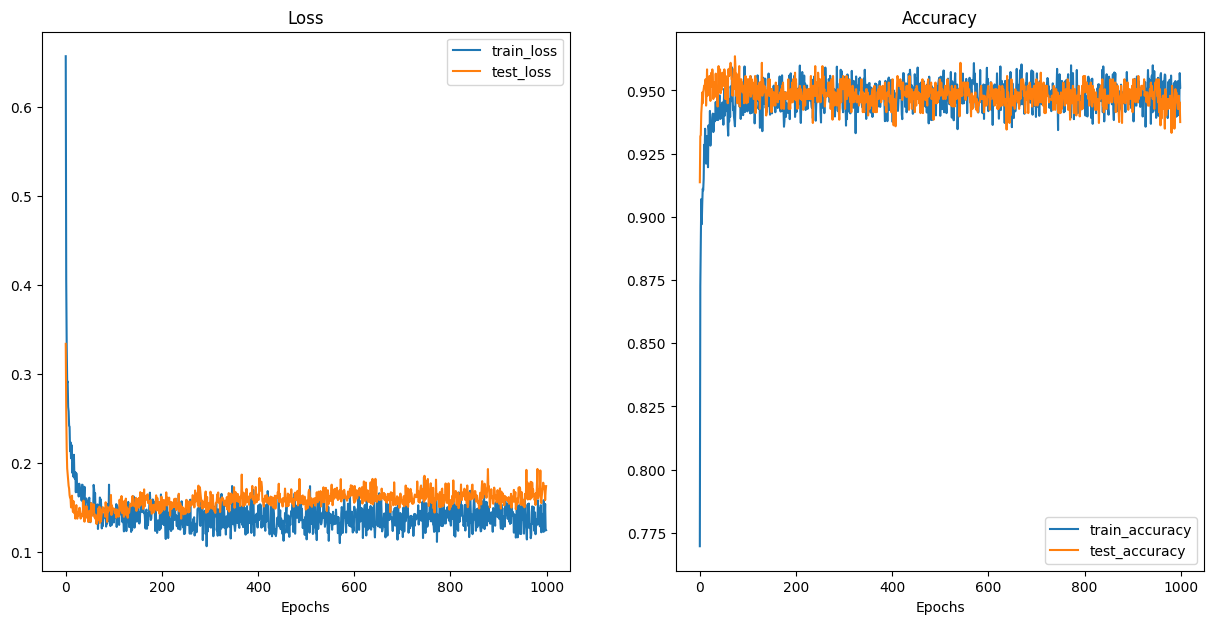

In [18]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

# 6. Making predictions in test set

Function to predict and plot

In [19]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ### 

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

Testing on some random images 

# Exercises

## Confusion Matrix
Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels.

Making predictions:   0%|          | 0/24 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


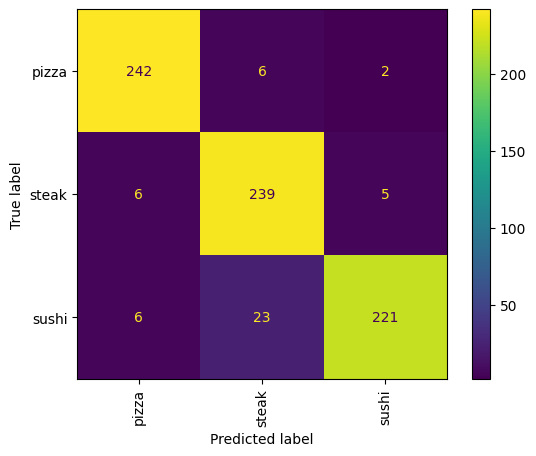

In [20]:

from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

test_truth = torch.cat([y for X, y in test_dataloader])

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(test_truth, y_pred_tensor, display_labels=class_names,xticks_rotation="vertical")
plt.show()
